In [1]:
# Author: Banafsheh Khazali, Emmett Collings
# Date: Oct 2, 2022

In [1]:
import networkx as nx # make sure you installed networkx
import numpy as np
import pandas as pd

In [2]:
# Data representation
df = pd.read_csv("../data/defense/defensemen_edgelist_corsi.csv")
df

,lineId,playerNames,position,games_played,icetime,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,...,playerId1,playerId2,player1Name,player2Name,goalsFor_per60,dZoneGiveaways_per60,corsi_influence_on_player1,corsi_influence_on_player2,corsi_influence_on_player1_stdDevs,corsi_influence_on_player2_stdDevs
0,84758258476902,Lindell-Hakanpaa,pairing,72,16662.0,0.46,0.410000,0.43,102.76,9.07,...,8475825,8476902,Jani Hakanpaa,Esa Lindell,1.944544,4.753331,-0.073153,-0.076468,-1.318670,-1.378440
1,84734468477073,Macdermid-Johnson,pairing,31,7478.0,0.54,0.520000,0.50,61.30,5.09,...,8473446,8477073,Erik Johnson,Kurtis MacDermid,2.407061,4.814121,0.009372,0.033348,0.168950,0.601145
2,84757968477462,Hagg-Pysyk,pairing,42,20841.0,0.44,0.460000,0.46,146.97,10.72,...,8475796,8477462,Mark Pysyk,Robert Hagg,1.381891,2.763783,-0.018159,-0.020400,-0.327331,-0.367744
3,84799988481600,Anderson-Bjornfot,pairing,27,14531.0,0.52,0.490000,0.50,122.30,10.77,...,8479998,8481600,Mikey Anderson,Tobias Bjornfot,2.477462,6.689147,-0.024500,0.010186,-0.441651,0.183614
4,84751818481542,Leddy-Seider,pairing,49,15204.0,0.51,0.470000,0.48,122.36,10.81,...,8475181,8481542,Nick Leddy,Moritz Seider,2.367798,3.788477,0.014153,0.000000,0.255119,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722,84741518478416,Mcdonagh-Cernak,pairing,132,82120.0,0.51,0.510781,0.49,193.54,16.67,...,8474151,8478416,Ryan McDonagh,Erik Cernak,2.498782,4.120799,0.024641,-0.029894,0.444187,-0.538870
723,84783968478397,Hanifin-Andersson,pairing,191,108070.0,0.57,0.539950,0.56,731.01,60.21,...,8478396,8478397,Noah Hanifin,Rasmus Andersson,2.998057,6.462478,0.026672,0.034082,0.480795,0.614370
724,84746028477969,Pettersson-Schultz,pairing,44,28948.0,0.54,0.530000,0.54,254.67,20.20,...,8474602,8477969,Justin Schultz,Marcus Pettersson,2.860301,4.974437,0.035070,0.006190,0.632187,0.111574
725,84746888477369,Soucy-Pateryn,pairing,12,8619.0,0.61,0.437709,0.45,13.33,1.27,...,8474688,8477369,Greg Pateryn,Carson Soucy,2.923773,2.506091,-0.027161,-0.038804,-0.489604,-0.699490


In [3]:
# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
df = df.rename(columns={'corsi_influence_on_player2':'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(df, 'playerId1', 'playerId2', ['weight'],create_using=nx.DiGraph)

df = df.rename(columns={'weight':'notweight','corsi_influence_on_player1':'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(df, 'playerId2', 'playerId1', edge_attr='weight',create_using=nx.DiGraph)

G = nx.compose(G0, G1)

# output a gephi file for ez visualization
nx.write_gexf(G, 'test.gexf')

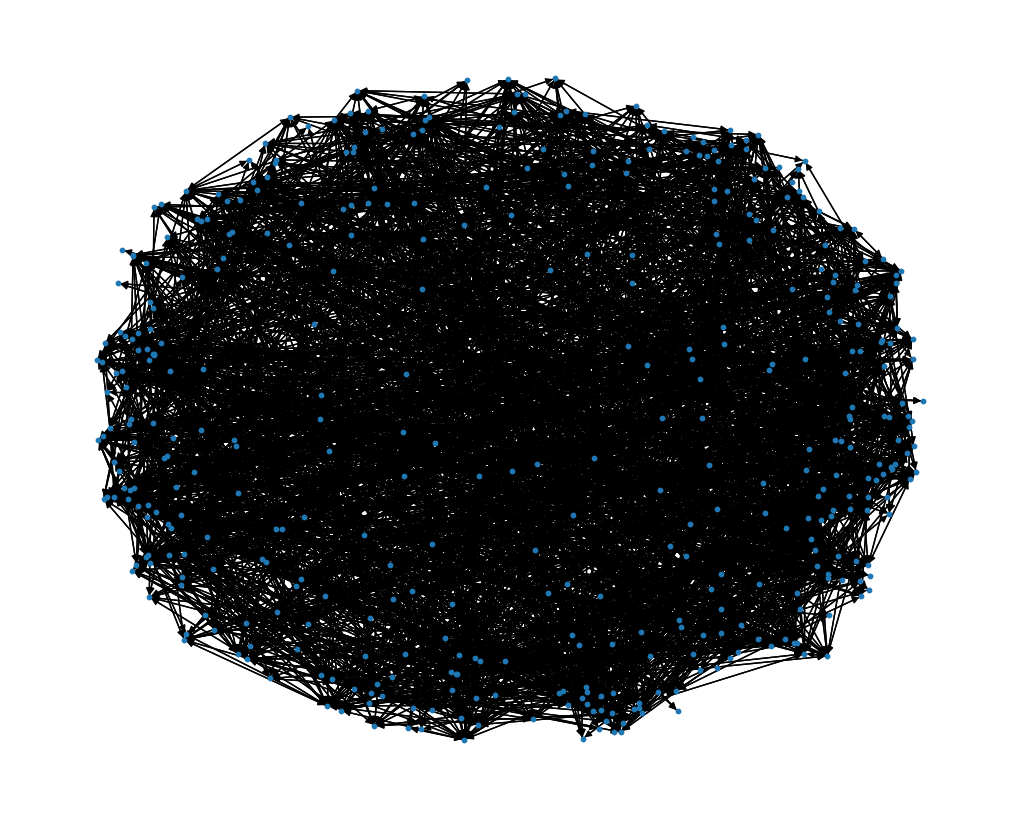

In [4]:
# Plot the network
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_spring(G, node_size=10)

In [125]:
# number of edges
G.number_of_edges()


4206

In [126]:
# number of nodes
G.number_of_nodes()

416

NetworkXNotImplemented: not implemented for directed type

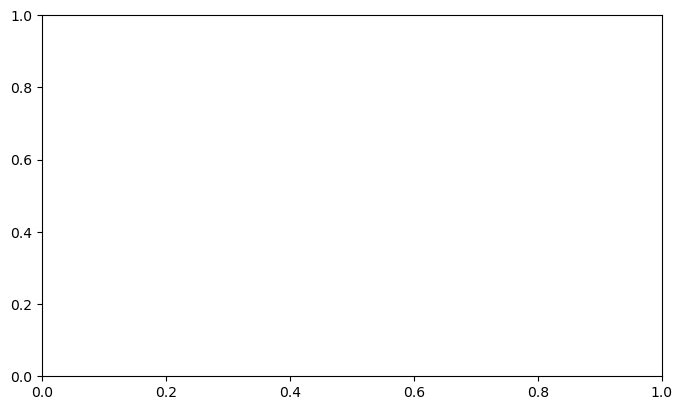

In [10]:
import matplotlib.pyplot as plt
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [101]:
#basic analysis
N = len(G)
L = G.size()
degrees = [G.degree(node) for node in G]
kmin = min(degrees)
kmax = max(degrees)

In [102]:
print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  416
Number of edges:  2103

Average degree:  10.110576923076923
Average degree (alternate calculation) 10.110576923076923

Minimum degree:  1
Maximum degree:  25


In [68]:
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


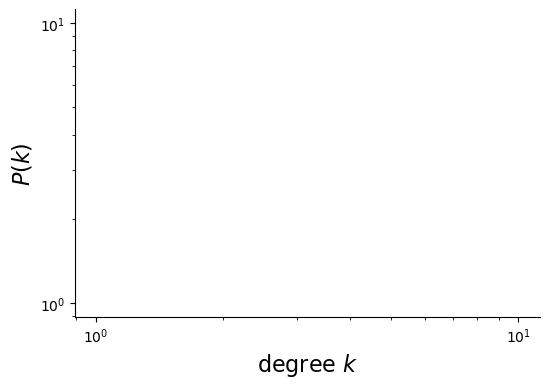

In [69]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

In [39]:
# Get 20 logarithmically spaced bins between kmin and kmax
bin_edges = np.linspace(kmin, 10, num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

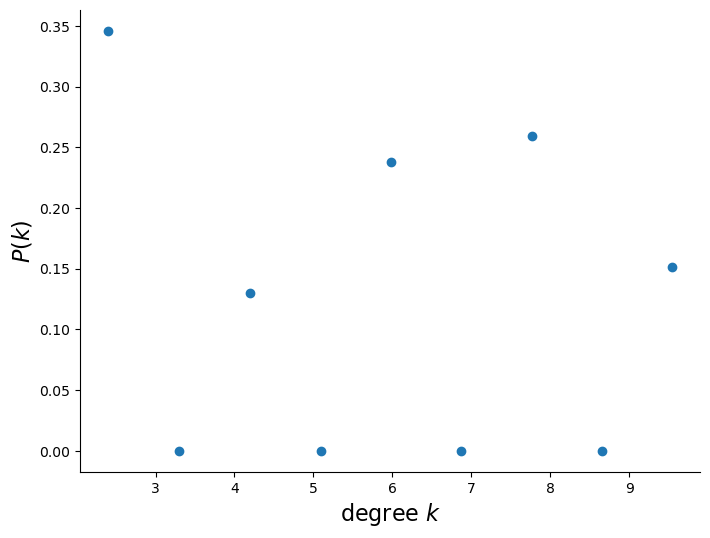

In [40]:
fig = plt.figure(figsize=(8,6))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

In [24]:
print(nx.info(G))

MultiDiGraph with 416 nodes and 4206 edges


/tmp/ipykernel_112855/2606185536.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


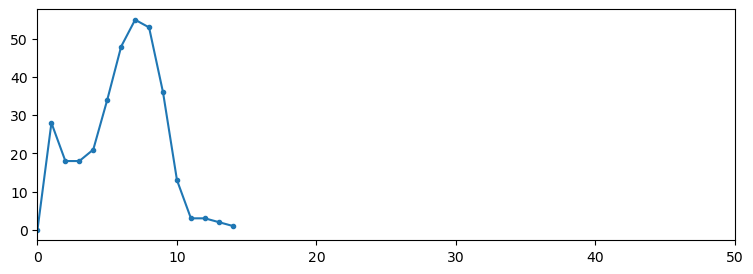

In [32]:
hist = nx.degree_histogram(G)
plt.figure(figsize=(9,3))
plt.plot(hist, marker = '.')
plt.xlim((0,50))
plt.show()

In [25]:
def all_networks(g, start, end):
    def plotpath(g, path):
        h = nx.subgraph(g, path)               
        nx.draw(h, pos = pos, node_color = 'r', edge_color = 'r', 
                node_size = 100, aplha = 0.7, width = 2)
             
    paths = nx.all_shortest_paths(g, source = start, target = end)
    paths = [i for i in paths]
    h = nx.subgraph(g, sum([i for i in paths], []))    
    labels = nx.get_node_attributes(h, 'label')   
    i = nx.subgraph(g, sum([nx.neighbors(g, i) for i in h.nodes()], []))  
    pos = nx.fruchterman_reingold_layout(i)
    
    plt.figure(figsize=(9,6))
    nx.draw(i, pos = pos, node_color = 'b', edge_color = 'b', node_size = 50, alpha = 0.5)
    [plotpath(g, i) for i in paths]
    nx.draw_networkx_labels(i, pos = pos, labels = labels, font_size = 10)
    plt.show()

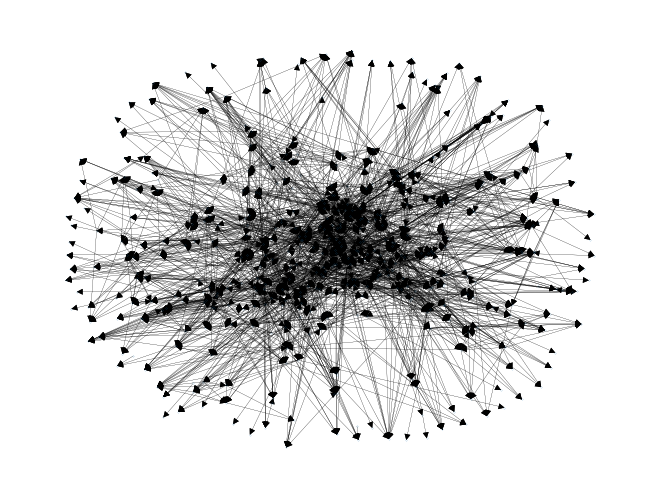

In [26]:
nx.draw(G, pos=nx.spring_layout(G), node_size=0.01, width=0.1)


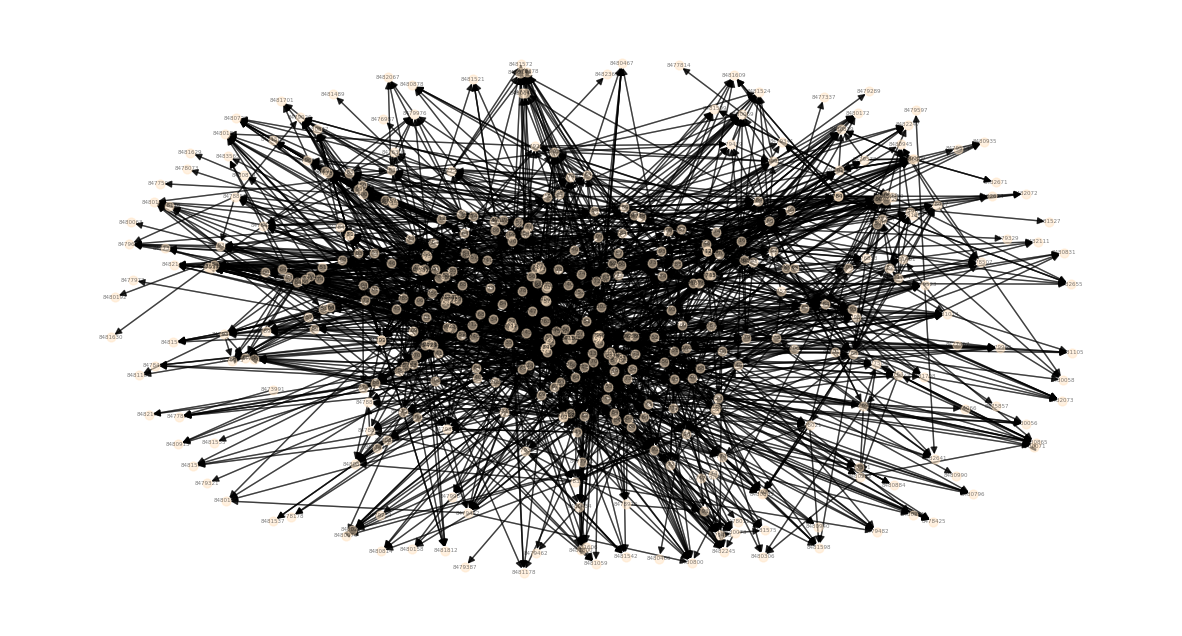

In [27]:
fig, ax = plt.subplots(figsize=(15, 8))

nx.draw_spring(G, node_color='bisque', with_labels=True , node_size = 40 , font_size = 4 , alpha = 0.5)